In [1]:
from modules import *
from functions import *

In [46]:
def plot_weights(trial=25, vmax=0.04):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3.4), dpi=180)
    im = axs[0].imshow(W[:, :, trial],vmin=0, vmax=vmax)
    axs[0].set_xticks([0, N/2, N-1]); axs[0].set_yticks([0, N/2, N-1])
    axs[0].set_xticklabels([0, 90, 180]); axs[0].set_yticklabels([0, 90, 180])
    axs[0].set_xlabel(r'post', fontstyle='italic')
    axs[0].set_ylabel(r'pre', fontstyle='italic')
    axs[0].invert_yaxis()

    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.locator_params(nbins=2)
    # cbar.formatter.set_powerlimits((0, 0))

    axs[1].scatter(preferences[:, 0], preferences[:, trial], s=15, alpha=0.2, fc='midnightblue', ec=None)
    axs[1].set_ylabel('PO day {}'.format((0+trial+1), fontsize=12, labelpad=15))
    axs[1].set_xlabel('PO day 1', labelpad=15)
    axs[1].set_xticks([0, 90, 180]); axs[1].set_yticks([0, 90, 180])
    axs[2].plot(median_change_per_day[:trial], c='k', ls='-', marker='o', ms=4)
    axs[2].set_ylim([0, 10])
    axs[2].locator_params(axis='y', nbins=2)

    axs[2].set_xlabel('Days')
    axs[2].set_ylabel(r'Median $ | \Delta PO | \; [\degree]$')
    
    sns.despine()
    fig.tight_layout(pad=2.5)
    

### Recovery

In [81]:
""" Deprivation """

N = int(300)     

theta_stim = 90
n_trials_init = 10
n_trials_deprv = 50
n_trials_recovery = 50

n_thetas = 100
n_test_angles = 100
init_trials = 10

rand_scaling = 1
hebb_scaling = 0.3
a=10
b=10

vars = np.random.lognormal(2, 0.6, N)
learning_rate = 1

W_init = initialise_W(N, vars)

""" Pre-runs """

# W = np.zeros((N, N, n_trials_deprv+1)); W[:, :, 0] = W_init

# for trial in range(n_trials_deprv):
#     W_old = W[:, :, trial]
#     H = hebbian_component(N, W_old, n_thetas, theta_stim, type='baseline')
#     eta = abs(np.random.randn(N, N))
#     W_new = W_old + (hebb_scaling * H * propensity_hebb(W_old, a) + rand_scaling * eta * propensity_rand(W_old, b)) * learning_rate
#     normalisation(W_new)
#     W[:, :, trial+1] = W_new

""" Stripe-rearing """ 

POs = []; W = np.zeros((N, N, n_trials_deprv+1)); # W[:, :, 0] = W_new

W[:, :, 0] = W_init
 
# Run trials
for trial in range(n_trials_deprv):
    W_old = W[:, :, trial]
    H = hebbian_component(N, W_old, n_thetas, theta_stim, type='stripe_rearing')
    eta = abs(np.random.randn(N, N))
    W_new = W_old + (hebb_scaling * H * propensity_hebb(W_old, a) + rand_scaling * eta * propensity_rand(W_old, b)) * learning_rate
    normalisation(W_new)
    W[:, :, trial+1] = W_new; 

    if trial==0: PO_initial = get_preferred_orientations(N, W_old, n_angles=n_test_angles)
    if trial==n_trials_deprv-1: PO_final = get_preferred_orientations(N, W_new, n_angles=n_test_angles)

W_final = W[:, :, -1]
change_during_deprivation = directional_circular_distance(PO_final, PO_initial)
# change_during_deprivation = directional_circular_distance(np.abs(PO_final - theta_stim), np.abs(PO_initial - theta_stim))

np.abs(PO_final - theta_stim)


""" Recovery """ 


POs = []; W = np.zeros((N, N, n_trials_recovery+1)); W[:, :, 0] = W_final

# Run trials
for trial in range(n_trials_recovery):
    W_old = W[:, :, trial]
    H = hebbian_component(N, W_old, n_thetas, theta_stim, type='baseline')
    eta = abs(np.random.randn(N, N))
    W_new = W_old + (hebb_scaling * H * propensity_hebb(W_old, a) + rand_scaling * eta * propensity_rand(W_old, b)) * learning_rate
    normalisation(W_new)
    W[:, :, trial+1] = W_new; 

    if trial==0:
        PO_initial = get_preferred_orientations(N, W_old, n_angles=n_test_angles)
    if trial==n_trials_recovery-1:
        PO_final = get_preferred_orientations(N, W_new, n_angles=n_test_angles)

change_during_recovery = directional_circular_distance(PO_final, PO_initial)
# change_during_recovery = directional_circular_distance(np.abs(PO_final - theta_stim), np.abs(PO_initial - theta_stim))


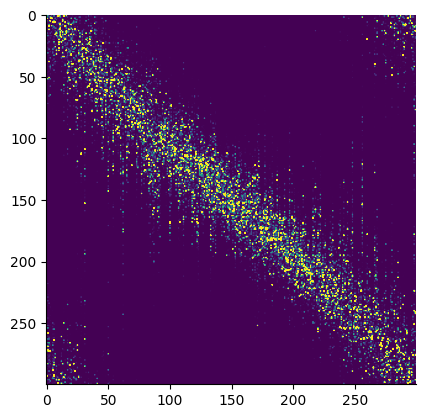

In [82]:
plt.imshow(W_final, vmin=0, vmax=0.04)

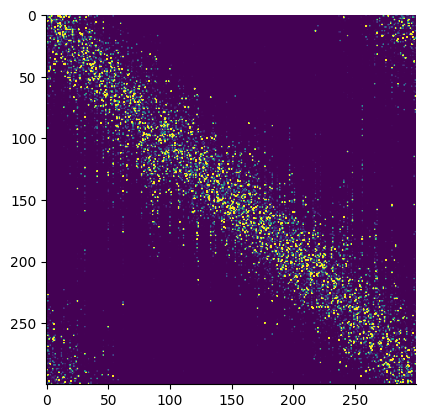

In [83]:
plt.imshow(W[:, :, -1], vmin=0, vmax=0.04)

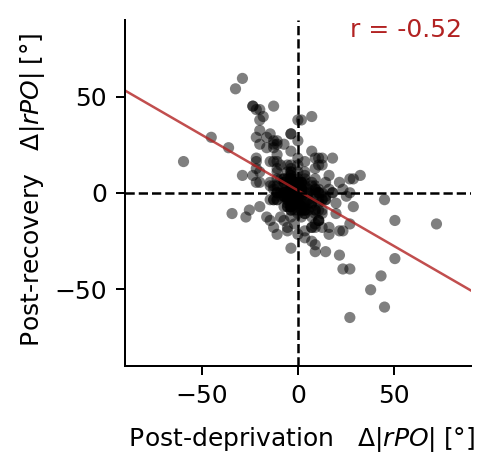

In [84]:
lim = 90

fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=180)
# sc = ax.scatter(change_during_deprivation, change_during_recovery, s=20, c='vars', norm=LogNorm(), ec=None, clip_on=False, alpha=0.8)   # coloured by variance
sc = ax.scatter(change_during_deprivation, change_during_recovery, s=20, c='k', ec=None, clip_on=False, alpha=0.5)

# colorbar
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='4%', pad=0.1)
# cbar = fig.colorbar(sc, cax=cax)
# cbar.set_label('Tuning curve width', rotation=270, labelpad=18)
# sc.set_clim(1, 40)

# plot correlation
slope, intercept, r_value, p_value, std_err = stats.linregress(change_during_deprivation, change_during_recovery)
x = np.linspace(-lim, lim, 100)
ax.plot(x, slope*x + intercept, c='firebrick', alpha=0.8, lw=1, zorder=2)
ax.text(0.65, 0.95, r'r = %.2f' % (r_value), transform=ax.transAxes, alpha=1, fontsize=10); ax.texts[0].set_color('firebrick')

ax.axvline(0, c='k', ls='--', lw=1)
ax.axhline(0, c='k', ls='--', lw=1)
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
# ax.set_yticks([-90, 0, 90])
ax.set_xlabel(r' Post-deprivation   $ \Delta | rPO | \; [\degree]$', fontsize=10, labelpad=7)
ax.set_ylabel(r' Post-recovery   $ \Delta | rPO | \; [\degree]$', fontsize=10, labelpad=3)
ax.set_aspect('equal') 

sns.despine()

# plt.savefig('figures/recovery_50_50_day.svg')

In [52]:
from scipy.stats import spearmanr

In [205]:
def evolve_weights(W, condition):
    H = hebbian_component(N, W, n_thetas, theta_stim, type=condition)
    eta = abs(np.random.randn(N, N))
    W_new = W + (hebb_scaling * H * propensity_hebb(W, a) + rand_scaling * eta * propensity_rand(W, b)) * learning_rate
    normalisation(W_new)
    return W_new


def get_correlation_recovery(total_days):

    # initialise weights for stripe-rearing 
    W_init = initialise_W(N, vars)
    W_deprv = np.zeros((N, N, total_days+1)); W_deprv[:, :, 0] = W_init
    POs_deprv = np.zeros((N, total_days+1)); POs_deprv[:, 0] = get_preferred_orientations(N, W_init, n_angles=n_test_angles)

    # stripe rearing period
    for day in range(total_days):
        W_old = W_deprv[:, :, day]
        W_new = evolve_weights(W_old, condition='stripe_rearing')
        W_deprv[:, :, day+1] = W_new
        POs_deprv[:, day+1] = get_preferred_orientations(N, W_new, n_angles=n_test_angles)      # current preferrered orientation on this day 

    change_during_deprivations = [directional_circular_distance(PO, np.linspace(0, 180, N)) for PO in POs_deprv.T]

    # recovery period
    W_rec = np.zeros((N, N, total_days+1)); 
    correlations = np.zeros((total_days+1, total_days+1))

    for sr_day in range(total_days):
        POs_rec = np.zeros((N, total_days+1)); POs_rec[:, 0] = get_preferred_orientations(N, W_deprv[:, :, sr_day], n_angles=n_test_angles)
        
        # initialise weights for recovery as those after each stripe-rearing day 
        W_rec[:, :, 0] = W_deprv[:, :, sr_day]

        for rec_day in range(total_days):
            W_old = W_rec[:, :, rec_day]
            W_new = evolve_weights(W_old, condition='baseline')
            W_rec[:, :, rec_day+1] = W_new
            POs_rec[:, rec_day+1] = get_preferred_orientations(N, W_new, n_angles=n_test_angles)      # current preferrered orientation on this day

        change_during_recoveries_after_this_sr_period = [directional_circular_distance(PO, POs_deprv[:, sr_day]) for PO in POs_rec.T]

        # plt.scatter(change_during_deprivations[sr_day], change_during_recoveries_after_this_sr_period[1])

        for rec_day in range(total_days+1):
            correlations[sr_day, rec_day] = np.corrcoef(change_during_deprivations[sr_day], change_during_recoveries_after_this_sr_period[rec_day])[0, 1]

    return correlations

In [227]:
total_days = 60
repeats = 10

all_correlations = np.zeros((repeats, total_days+1, total_days+1))

for repeat in tqdm(range(repeats)):
    all_correlations[repeat] = get_correlation_recovery(total_days)

100%|██████████| 10/10 [38:41<00:00, 232.14s/it]


In [235]:
# concatenate all_correlations and all_correlations1[:, :61, :61] 

all_correlations = np.concatenate((all_correlations, all_correlations1[:, :61, :61]), axis=0)

In [53]:
recovery_correlation_matrix = np.loadtxt('/Users/administrator/Library/CloudStorage/GoogleDrive-bh072197@gmail.com/My Drive/1/Drift/scripts/paper/recovery_correlation_matrix', delimiter=",")

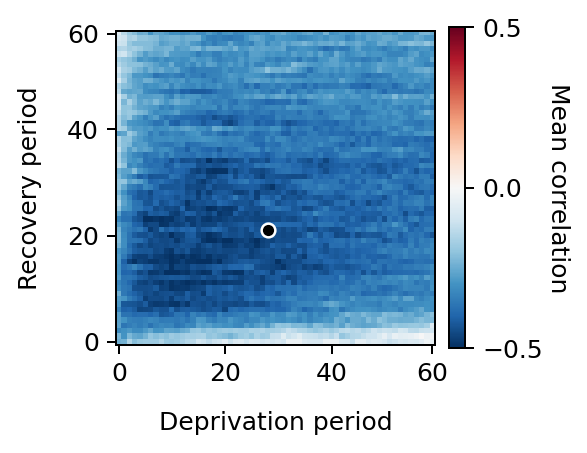

In [57]:
n_ticks = 3

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=180)
cbar_max = 0.5
# ax.imshow(all_correlations[4],  cmap='RdBu_r', vmin=-cbar_max, vmax=cbar_max) #, extent=[-1, nx, -1, ny])

blue_cmap = cmr.get_sub_cmap('RdBu_r', 0, 0.5)

im1 = ax.imshow(recovery_correlation_matrix,  cmap='RdBu_r', vmin=-cbar_max, vmax=cbar_max)
im2 = ax.imshow(recovery_correlation_matrix,  cmap=blue_cmap, vmin=-0.49, vmax=-.15)

cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel(r'Mean correlation', rotation=-90, va="bottom", labelpad=1) #, fontweight='bold')
cbar.set_ticks(np.arange(-0.5, 0.51, 0.5))
ax.set_xlabel(r'Deprivation period', labelpad=10)
ax.set_ylabel(r'Recovery period', labelpad=10)
ax.set_xticks([0, 20, 40, 59])
ax.set_xticklabels([0, 20, 40, 60])
ax.set_yticks([0, 20, 40, 58])
ax.set_yticklabels([0, 20, 40, 60])
ax.invert_yaxis()
ax.set_facecolor('k')
ax.set_aspect('equal')
sns.despine(top=False, right=False)

# ax.axhline(21, color='w', linestyle='--', linewidth=0.5)
# ax.axvline(28, color='w', linestyle='--', linewidth=0.5)

ax.scatter(28, 21, ec='w', fc='k', s=30, zorder=3)

# np.savetxt('recovery_correlation_matrix', np.mean(all_correlations, axis=0)[1:-1, 1:], delimiter=",")

# plt.savefig('figures/recovery_deprivation_vs_baseline.svg')


In [81]:
""" Stripe-rearing length vs. recovery length """

def get_correlation_recovery(n_stripe_rearing, n_recovery, n_test_angles, n_repeats):

    pearson = []
    for repeat in range(n_repeats):
        
        W_init = initialise_W(N, vars)
        
        # Stripe-rearing
        W = np.zeros((N, N, n_stripe_rearing+1)); W[:, :, 0] = W_init
        for trial in range(n_stripe_rearing):
            W_old = W[:, :, trial]
            H = hebbian_component(N, W_old, n_thetas, theta_stim, type='stripe_rearing')
            eta = abs(np.random.randn(N, N))
            W_new = W_old + (hebb_scaling * H * propensity_hebb(W_old, a) + rand_scaling * eta * propensity_rand(W_old, b)) * learning_rate
            normalisation(W_new)
            W[:, :, trial+1] = W_new; 
            if trial==n_stripe_rearing-1: PO_final = get_preferred_orientations(N, W_old, n_angles=n_test_angles)
        change_during_deprivation = directional_circular_distance(PO_final, np.linspace(0, 180, N))

        # Recovery
        W_final = W[:, :, -1]; POs = []
        W = np.zeros((N, N, n_recovery+1)); W[:, :, 0] = W_final
        
        for trial in range(n_recovery):
            W_old = W[:, :, trial]
            H = hebbian_component(N, W_old, n_thetas, theta_stim, type='baseline')
            eta = abs(np.random.randn(N, N))
            W_new = W_old + (hebb_scaling * H * propensity_hebb(W_old, a) + rand_scaling * eta * propensity_rand(W_old, b)) * learning_rate
            normalisation(W_new)
            W[:, :, trial+1] = W_new
            if trial==0: PO_initial = get_preferred_orientations(N, W_old, n_angles=n_test_angles)
            if trial==n_recovery-1: PO_final = get_preferred_orientations(N, W_old, n_angles=n_test_angles)

        change_during_recovery = directional_circular_distance(PO_final, PO_initial)
        
        pears = np.corrcoef(change_during_deprivation, change_during_recovery)[0, 1]
        spear, _ = spearmanr(change_during_deprivation, change_during_recovery)
        pearson.append(pears)
        spearman.append(spear)
    return pearson, spearman



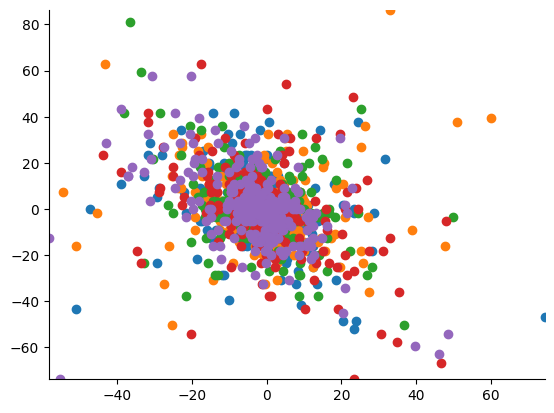

In [84]:
pearson, spearman = get_correlation_recovery(n_stripe_rearing=30, n_recovery=30, n_test_angles=100, n_repeats=5)